# Hands on DeePMD-kit (ICMRE2023)


通过本notebook，以温稠密铝($\rho = 2.7\ \rm{g/cm^3}$, $T = 1\ \rm{eV} = 11605 K$）的势函数训练为案例

> 1）了解DeePMD-kit的训练集数据格式，学会dpdata的基本使用，
>
> 2）熟悉deepmd-kit的输入脚本，学会DP势函数训练、模型冻结、压缩与测试；
>
> 3）在分子动力学模拟软件LAMMPS中使用训练DP势开展模拟



In [4]:
! cd ~ && tree hands_on_dpkit_ICMRE2023 -L 1

hands_on_dpkit_ICMRE2023 [error opening dir]

0 directories, 0 files


# 1 : data preparation

##  1-1 了解训练集的标准格式

`00.data/raw_data`内包含了400帧(frame)的原子构型，每帧包含32个Al原子，其数据集基本构成为：

- `box.raw`与`coord.raw`， 用于描述模拟盒子的张量，以及盒子内所有原子的笛卡尔坐标，每行分别包含9、96 ($3\times N_{atoms}$)个分量。

- `type.raw` 和 `type_map.raw`， 用于标记每个原子的元素类型（用数字区分`0,1,2...`），与数字对于的元素标记（`Al`）

- `energy.raw`, `force.raw`, `virial.raw`，分别为能量、受力与维里张量，每行分别为1，$3\times N_{atoms}$, 9个分量。

- `fparam.raw`， 每帧所指定的额外参数，如温度值，其每行分量与输入文件中的`numb_fparam`应相匹配。



In [7]:
! cd ~/hands_on_dpkit_ICMRE2023/00.data/raw_data && wc -l *

    400 box.raw
    400 coord.raw
    400 energy.raw
    400 force.raw
    400 fparam.raw
     32 type.raw
      1 type_map.raw
    400 virial.raw
   2433 total



## 1-2 上手使用dpdata来划分数据集（训练集与测试集）

- 通过`ss = dpdata.LabeledSystem()`来读入不同格式的原始数据（可以读入ABACUS/QE/VASP等不同第一性原理计算软件的分子动力学轨迹文件）

- 通过`ss.to_deepmd_npy()`来生成二进制的numpy格式，以供dpkit在模型训练步骤读入。

（注意，fparam对于参数的格式没有单独的限制，因此一般由手动提取和产生，而非使用dpdata）


In [9]:
import os
import numpy as np
import dpdata

ROOT = '/root/hands_on_dpkit_ICMRE2023/00.data/'

RAW_DIR = os.path.join(ROOT, 'raw_data')

# ======================= 
# read raw dataset
# ======================= 
ss = dpdata.LabeledSystem( RAW_DIR, fmt='deepmd/raw')
nframes = ss.get_nframes()
print('# dataset contains : %d frames' % nframes )

fparam = np.loadtxt( os.path.join(RAW_DIR, 'fparam.raw') )

# ======================= 
# divide the dataset  
# ratio = 1:4 (validation:training)
# =======================
index_validation = np.random.choice(nframes, size= int(nframes/5), replace=False)
index_training = list(set(range(nframes))-set(index_validation))

data_training = ss.sub_system(index_training)
data_validation = ss.sub_system(index_validation)


data_training.to_deepmd_npy( os.path.join(ROOT, 'training_data') )
np.save( os.path.join(ROOT, 'training_data', 'set.000', 'fparam.npy'), 
        fparam[index_training])

data_validation.to_deepmd_npy( os.path.join(ROOT, 'validation_data') )
np.save( os.path.join(ROOT, 'validation_data', 'set.000', 'fparam.npy'), 
        fparam[index_validation])

print('# traning set contains : %d frames' % len(data_training)) 
print('# validation set contains : %d frames' % len(data_validation))

#ss.to_deepmd_npy( SET_DIR )
#np.save( os.path.join(SET_DIR, 'fparam.npy'), fparam)


# dataset contains : 400 frames
# traning set contains : 320 frames
# validation set contains : 80 frames


In [10]:
! tree ~/hands_on_dpkit_ICMRE2023/00.data/ -L 1

/root/hands_on_dpkit_ICMRE2023/00.data/
├── raw_data
├── training_data
└── validation_data

3 directories, 0 files


In [12]:
! tree ~/hands_on_dpkit_ICMRE2023/00.data/training_data -L 1

/root/hands_on_dpkit_ICMRE2023/00.data/training_data
├── set.000
├── type.raw
└── type_map.raw

1 directory, 2 files


In [15]:
! cat ~/hands_on_dpkit_ICMRE2023/00.data/training_data/type_map.raw

Al


# 2 : using DeePMD-kit

## 2-1 了解和准备输入文件

输入文件为json格式，主要分为四个部分

- `model`，声明模型参数，包括描述子类型、网络结构

- `learning_rate`，学习率的变化

- `loss`，损失函数的权重

- `training`，声明训练步数，测试集与验证集的路径


其他

- hybrid描述子

- frame parameter or atomic parameter

- DeepDOS model

- 继续训练与模型微调


In [1]:
! cd ~/hands_on_dpkit_ICMRE2023/01.train/ && cat input.json

{
    "_comment": " model parameters",
    "model": {
	"type_map":	["Al"],
	"descriptor" :{
	    "type":		"se_e2_a",
	    "sel":		"auto",
	    "rcut_smth":	0.50,
	    "rcut":		6.00,
	    "neuron":		[25, 50, 100],
	    "resnet_dt":	false,
	    "axis_neuron":	16,
	    "seed":		1,
	    "_comment":		" that's all"
	},
	"fitting_net" : {
	    "neuron":		[240, 240, 240],
	    "resnet_dt":	true,
	    "seed":		1,
      "numb_fparam": 0,
	    "_comment":		" that's all"
	},
	"_comment":	" that's all"
    },

    "learning_rate" :{
	"type":		"exp",
	"decay_steps":	50,
	"start_lr":	0.001,	
	"stop_lr":	3.51e-8,
	"_comment":	"that's all"
    },

    "loss" :{
	"type":		"ener",
	"start_pref_e":	0.02,
	"limit_pref_e":	1,
	"start_pref_f":	1000,
	"limit_pref_f":	1,
	"start_pref_v":	0.02,
	"limit_pref_v":	1,
	"_comment":	" that's all"
    },

    "training" : {
	"training_data": {
	    "systems":     ["../00.data/training_data"],
	    "batch_size":  "auto",
	    "_comment":	   "that's all"
	},
	"validatio

## 2-2 模型训练

通过`dp train input.json`命令，来执行模型训练


In [22]:
! cd ~/hands_on_dpkit_ICMRE2023/01.train/ && dp train input.json

2023-05-30 21:26:24.035152: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-30 21:26:26.844574: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/mpi/gcc/openmpi-4.1.0rc5/lib:/usr/local/nccl-rdma-sharp-plugins/lib:/usr/local/nvidia/lib64:/usr/local/cuda/lib64:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-05-30 21:26:26.846213: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: N


## 2-2-b 损失函数可视化

输出得到的主要文件为`lcurve.out`，它表示随着训练进行，神经网络预测的能量、受力与维里张量在训练集、验证集上的误差变化。


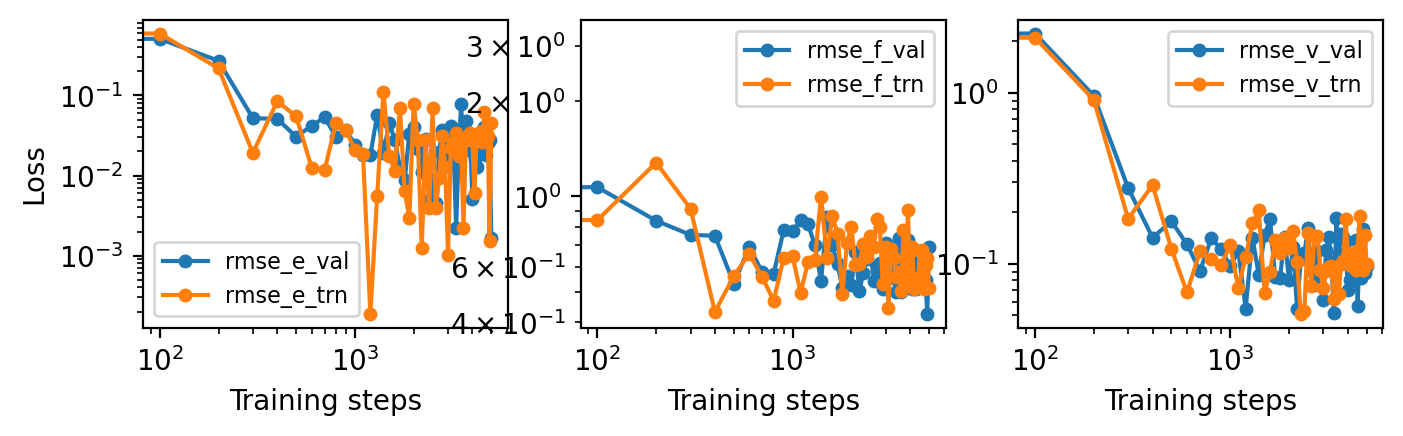

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

with open("/root/hands_on_dpkit_ICMRE2023/01.train/lcurve.out") as f:
    headers = f.readline().split()[1:]
    
lcurve = pd.DataFrame(np.loadtxt("/root/hands_on_dpkit_ICMRE2023/01.train/lcurve.out"), columns=headers)
legends = ["rmse_e_val", "rmse_e_trn", "rmse_f_val" , "rmse_f_trn", "rmse_v_val",  "rmse_v_trn" ]

fig, ax1 = plt.subplots(1,3, figsize=(8,2),dpi=200)

for idx in range(3):
    
    ax = ax1[idx]
    ax.plot(lcurve["step"], lcurve[legends[idx * 2]], 
            '-o', ms=4, label=legends[idx * 2])
    ax.plot(lcurve["step"], lcurve[legends[idx * 2 + 1]], 
            '-o', ms=4, label =legends[idx * 2 + 1])

    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.legend(fontsize=8)
    
    ax.set_xlabel("Training steps")
    
    if idx == 0:
        ax.set_ylabel("Loss")
    


## 2-3 模型冻结与压缩

通过模型冻结，`dp freeze -o frozen_model.pb`，我们可以得到直接用于LAMMPS模拟的势函数文件。

为了进一步提高计算效率，我们会通过`dp compress -i frozen_model.pb -o cp.pb -t input.json`来进行模型压缩


In [3]:
! cd /root/hands_on_dpkit_ICMRE2023/01.train/ && dp freeze -o frozen_model.pb 

2023-05-30 22:31:49.687480: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-30 22:31:50.830700: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/mpi/gcc/openmpi-4.1.0rc5/lib:/usr/local/nccl-rdma-sharp-plugins/lib:/usr/local/nvidia/lib64:/usr/local/cuda/lib64:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-05-30 22:31:50.830826: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: N

In [4]:
! cd /root/hands_on_dpkit_ICMRE2023/01.train/ && dp compress -i frozen_model.pb -o cp.pb -t input.json

2023-05-30 22:32:04.442464: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-30 22:32:05.573375: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/mpi/gcc/openmpi-4.1.0rc5/lib:/usr/local/nccl-rdma-sharp-plugins/lib:/usr/local/nvidia/lib64:/usr/local/cuda/lib64:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-05-30 22:32:05.573514: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: N

## 2-4 dp test

为了验证模型在任意数据集上的测试效果，我们可以对给定数据集通过`dp test`来实现模型推断。

模型对根据结构文件来预测能量、受力与维里，从而与已有的标签进行对比，评估模型精度。


In [5]:
! cd /root/hands_on_dpkit_ICMRE2023/01.train/ && dp test -m cp.pb -s ../00.data/validation_data -d vali -n 100

2023-05-30 22:32:15.373398: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-30 22:32:16.486201: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/mpi/gcc/openmpi-4.1.0rc5/lib:/usr/local/nccl-rdma-sharp-plugins/lib:/usr/local/nvidia/lib64:/usr/local/cuda/lib64:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-05-30 22:32:16.486321: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: N

Text(0, 0.5, '$E_{DP}$ (eV)')

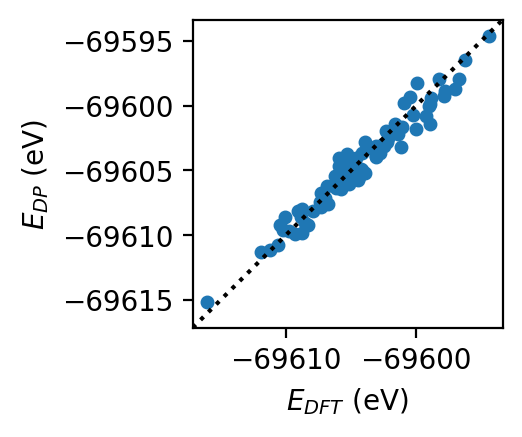

In [7]:
import numpy as np
import matplotlib.pyplot as plt

data = np.loadtxt("/root/hands_on_dpkit_ICMRE2023/01.train/vali.e.out")

fig, ax = plt.subplots(figsize=(2,2),dpi=200)

ax.plot(data[:,0], data[:,1], 'o', ms=4)

x_lim = np.linspace(plt.xlim()[0], plt.xlim()[1])
ax.plot(x_lim, x_lim, ':k',)

ax.set_xlim(x_lim[0], x_lim[-1])
ax.set_ylim(x_lim[0], x_lim[-1])

ax.set_xlabel('$E_{DFT}$ (eV)')
ax.set_ylabel('$E_{DP}$ (eV)')

对于受力来说，其有3个分量，因此总共输出有6个列，分别为DFT,DP的x,y,z三个方向受力

某一个frame的受力误差为各分量的均方根偏差（root mean square error, RMSE）平均，

$$\parallel f \parallel = \frac{1}{3} \sum_{x,y,z} \sqrt{ (f_{DFT,i}-f_{DP,i})^2 }$$

维里张量为对称的3x3张量，有9个分量, 计算RMSE及绘制方法同上。


Text(0, 0.5, '$f_{DP}$ ($\\rm{eV\\mathring A}$)')

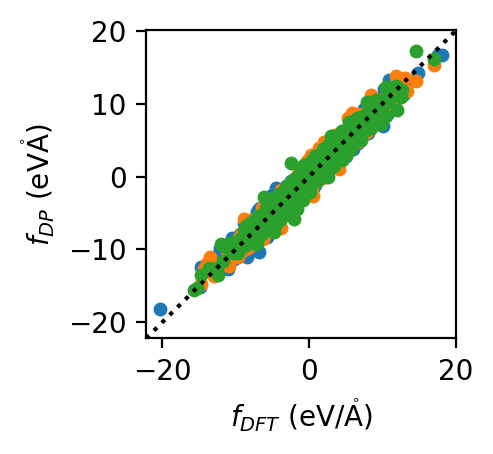

In [8]:
data = np.loadtxt("/root/hands_on_dpkit_ICMRE2023/01.train/vali.f.out")

fig, ax = plt.subplots(figsize=(2,2),dpi=200)

ll = ['$f_x$', '$f_y$', '$f_z$']

for i in range(3):

    ax.plot(data[:,i], data[:,i + 3], 'o', ms=4, label=ll[i])

x_lim = np.linspace(plt.xlim()[0], plt.xlim()[1])
ax.plot(x_lim, x_lim, ':k',)

ax.set_xlim(x_lim[0], x_lim[-1])
ax.set_ylim(x_lim[0], x_lim[-1])

ax.set_xlabel('$f_{DFT}$ ($\\rm{eV/\mathring A}$)')
ax.set_ylabel('$f_{DP}$ ($\\rm{eV\mathring A}$)')

Text(0, 0.5, '$v_{DP}$ ($\\rm{eV}$)')

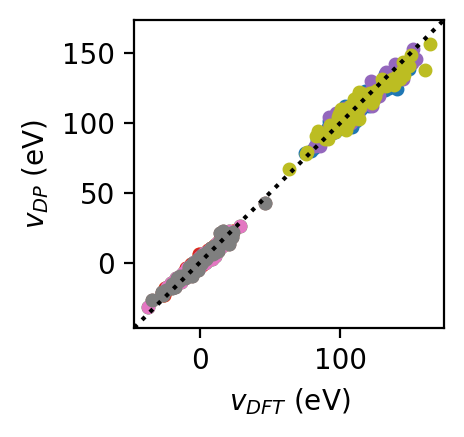

In [9]:
data = np.loadtxt("/root/hands_on_dpkit_ICMRE2023/01.train/vali.v.out")

fig, ax = plt.subplots(figsize=(2,2),dpi=200)

for i in range(9):

    ax.plot(data[:,i], data[:,i + 9], 'o', ms=4,)

x_lim = np.linspace(plt.xlim()[0], plt.xlim()[1])
ax.plot(x_lim, x_lim, ':k',)

ax.set_xlim(x_lim[0], x_lim[-1])
ax.set_ylim(x_lim[0], x_lim[-1])

ax.set_xlabel('$v_{DFT}$ ($\\rm{eV}$)')
ax.set_ylabel('$v_{DP}$ ($\\rm{eV}$)')

# 4 LAMMPS

在安装有USER-DEEPMD模块的LAMMPS中，我们可以通过

不含`fparam`的势函数，为
```
pair_style     deepmd cp.pb
pair_coeff     * *

```

含`fparam`的势函数，可以定义常数的fparam值，或者是通过定义LAMMPS的`compute`命令来获得一个实时更新的全局变量值作为fparam
```
variable       T equal 11605
pair_style     deepmd cp.pb fparam $T
pair_coeff     * *

```

```
compute        TEMP all temp
pair_style     deepmd cp.pb fparam_from_compute TEMP
pair_coeff     * *

```

In [10]:
! cd /root/hands_on_dpkit_ICMRE2023/02.lmp && cp ../01.train/cp.pb ./ && tree -L 1

.
├── cp.pb
└── init.in

0 directories, 2 files


In [12]:
! cd /root/hands_on_dpkit_ICMRE2023/02.lmp && lmp -i init.in

/usr/bin/sh: 1: lmp_mpi: not found
